In [1]:
import tensorflow as tf
tf.enable_eager_execution()


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import h5py
import os, math, gc
from tqdm import tqdm
import cv2
import gc

# Dataset creation
To be able to input the DeepFashion dataset, we need to massage it into a format accepted by the Glow model.

In [22]:
PROJECT_DIR = '/project/fashion-flow'
DATA_DIR = os.path.join(PROJECT_DIR, 'data')
DEEPFASHION_DIR = os.path.join(DATA_DIR, 'DeepFashion', 'FashionSynthesis')
IMG_PER_CHUNK = 225
TEST_RATIO = .25
IMAGE_SIZE = 64
DEFAULT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)
DEFAULT_LABEL = [0]

### Reading in h5 file

In [4]:
f = h5py.File(os.path.join(DEEPFASHION_DIR, 'G2.h5'), 'r')
segmentations_ds = f['b_']
images_ds = f['ih']
N = len(images_ds)

In [66]:
# ghost = f['ih_mean'].value

In [27]:
# images_ds2 = images_ds.value.transpose(0,2,3,1)

In [28]:
# print(ghost.shape)
# ghost = ghost.transpose(1,2,0)
# print(ghost.shape)

In [29]:
# #Resizing
# res_images_ds = np.zeros((images_ds.shape[0],64,64,3))
# for idx in range(len(images_ds)):
#     res_images_ds[idx,:] = cv2.resize(images_ds2[idx], (64, 64), interpolation = cv2.INTER_AREA)


In [30]:
# print(ghost.shape)
# ghost = cv2.resize(ghost, (64, 64), interpolation = cv2.INTER_AREA)
# print(ghost.shape)

In [31]:
# print(res_images_ds.shape)
# res_images_ds = res_images_ds.transpose(0,3,1,2)
# print(res_images_ds.shape)

In [32]:
# ghost = ghost.transpose(2,0,1)

The channel is in front and the images are rotated 90 degrees by default. So we will take the transpose of the images as well as the ghosts.

In [70]:
i = 236

(3, 128, 128)


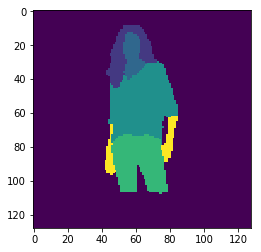

In [71]:
print(images_ds[0].shape)
_=plt.imshow(segmentations_ds[i][0].T)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(128, 128, 3)


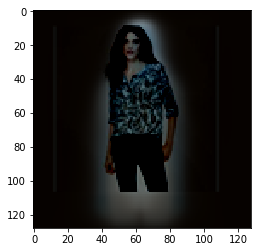

In [72]:
print(images_ds[i].T.shape)
_=plt.imshow(images_ds[i].T)

### Forming train, test splits

We will extract the images out from the h5 dataformat into a list of chunks.

In [14]:
images, segmentations = shuffle(images_ds.value, segmentations_ds.value)

In [16]:
train_images, test_images, train_segmentations, test_segmentations = train_test_split(
    images, segmentations, test_size=TEST_RATIO, shuffle=False)

In [17]:
train_img_chunks = []
train_seg_chunks = []
for i in range(math.floor(len(train_images)//IMG_PER_CHUNK)):
    train_img_chunks.append(train_images[i*IMG_PER_CHUNK:(i+1)*IMG_PER_CHUNK])
    train_seg_chunks.append(train_segmentations[i*IMG_PER_CHUNK:(i+1)*IMG_PER_CHUNK])

test_img_chunks = []
test_seg_chunks = []
for i in range(math.floor(len(test_images)//IMG_PER_CHUNK)):
    test_img_chunks.append(test_images[i*IMG_PER_CHUNK:(i+1)*IMG_PER_CHUNK])
    test_seg_chunks.append(test_segmentations[i*IMG_PER_CHUNK:(i+1)*IMG_PER_CHUNK])

The leftovers

In [18]:
train_img_chunks.append(train_images[(math.floor(len(train_images)//IMG_PER_CHUNK))*IMG_PER_CHUNK:])
train_seg_chunks.append(train_segmentations[(math.floor(len(train_images)//IMG_PER_CHUNK))*IMG_PER_CHUNK:])

test_img_chunks.append(test_images[(math.floor(len(test_images)//IMG_PER_CHUNK))*IMG_PER_CHUNK:])
test_seg_chunks.append(test_segmentations[(math.floor(len(test_images)//IMG_PER_CHUNK))*IMG_PER_CHUNK:])

In [19]:
print('{} train chunks.'.format(len(train_img_chunks)))
print('{} test chunks.'.format(len(test_img_chunks)))
print('Total of {} chunks.'.format(len(train_img_chunks) + len(test_img_chunks)))
assert len(train_img_chunks) + len(test_img_chunks) == len(train_seg_chunks) + len(test_seg_chunks) == N//IMG_PER_CHUNK + 1 if N%IMG_PER_CHUNK!=0 else 0

264 train chunks.
88 test chunks.
Total of 352 chunks.


The shuffle method creates a copy, so we can delete the images and segmentations to make room in RAM.

In [20]:
del images, segmentations
gc.collect()

2369

### Serializing to Tensorflow examples

Our images are sized the same and we will be exploring unconditional training so we can set our shape and label as constants.

In [23]:
print('Final shape of images will be: {}'.format(DEFAULT_SHAPE))
print('Default label: {}'.format(DEFAULT_LABEL))

Final shape of images will be: (64, 64, 3)
Default label: [0]


In [24]:
def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[*value]))

def _bytes_feature(value):
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

In [47]:
def resize_image(image, size=IMAGE_SIZE):
    return cv2.resize(image, (size, size), interpolation = cv2.INTER_AREA)

In [48]:
def encode_image(image, seg=None):
    out = tf.image.convert_image_dtype(image + ghost if seg is None else image, dtype=tf.uint8).numpy()
    return out.tostring()

In [49]:
def serialize_example(img, seg=None, shape=DEFAULT_SHAPE, label=DEFAULT_LABEL):
    '''
    Creates a tf.Example message ready to be written to a file.
    '''
    # Transpose image
    img = img.T
    # Resize image
    if img.shape[0] != shape[0]:
        img = resize_image(img)
    # Encode the image
    img = encode_image(img)
    # Create a dictionary mapping the feature name to the tf.Example-compatible data type.
    feature = {
        'shape': _int64_feature(shape),
        'data': _bytes_feature(img),
        'label': _int64_feature(label),
    } 
    if seg is not None:
        seg = encode_image(seg, True)
        feature['seg'] = _bytes_feature(seg)
    # Create a Features message using tf.train.Example.
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

In [50]:
def parse_tfrecord_tf(record, res, rnd_crop, seg=None):
    look_for = {
        'shape': tf.FixedLenFeature([3], tf.int64),
        'data': tf.FixedLenFeature([], tf.string),
        'label': tf.FixedLenFeature([1], tf.int64)
    }
    if seg is not None:
        look_for['seg'] = tf.FixedLenFeature([], tf.string)
    features = tf.parse_single_example(record, features=look_for)
    # to get CelebA attr, add 'attr': tf.FixedLenFeature([40], tf.int64)
    data, label, shape = features['data'], features['label'], features['shape']
    label = tf.cast(tf.reshape(label, shape=[]), dtype=tf.int32)
    img = tf.decode_raw(data, tf.uint8)
    if rnd_crop:
        # For LSUN Realnvp only - random crop
        img = tf.reshape(img, shape)
        img = tf.random_crop(img, [res, res, 3])
    img = tf.reshape(img, [res, res, 3])
    if seg is not None:
        seg = features['seg']
        seg = tf.decode_raw(seg, tf.uint8)
        seg = tf.reshape(seg, [res, res, 1])
        return img, seg, label
    return img, label  # to get CelebA attr, also return attr

This is all the massaging needed to get our serialized example, let's give it a try with a sample image and segmentation map.

In [54]:
ghost = resize_image(f['ih_mean'].value.T)

In [56]:
i = 101
sample_img = train_images[i]
sample_seg = train_segmentations[i]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 128, 128)

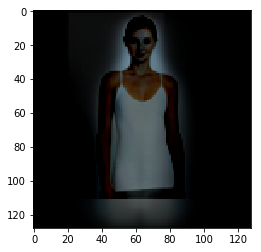

In [60]:
plt.imshow(sample_img.T)
sample_img.shape

In [59]:
sample_serialized = serialize_example(sample_img)
print('sample_serialized: {}...'.format(sample_serialized[:100]))

sample_serialized: b'\n\xb4`\n\x0e\n\x05label\x12\x05\x1a\x03\n\x01\x00\n\x10\n\x05shape\x12\x07\x1a\x05\n\x03@@\x03\n\x8f`\n\x04data\x12\x86`\n\x83`\n\x80`\xee\xee\xee\xee\xee\xee\xee\xee\xee\xee\xee\xee\xee\xee\xee\xee\xee\xee\xee\xee\xee\xee\xee\xee\xee\xee\xee\xee\xee\xee\xf1\xf1\xf1\xf1\xf1\xf1\xf1\xf1\xf1\xf1\xf1\xf1\xf1\xf1\xf1'...


Let's see if everything is working by parsing the serialized example.

In [62]:
img, label = parse_tfrecord_tf(sample_serialized, res=IMAGE_SIZE, rnd_crop=False, seg=None)

TensorShape([Dimension(64), Dimension(64), Dimension(3)])

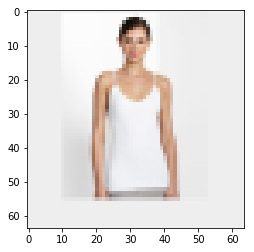

In [64]:
plt.imshow(img)
img.shape

### Exporting tfrecords 

Filename format will be:
```
{split}-r{log2(:02 resolution)}-s-{:04 chunk}-of-{:04 num_chunks}.tfrecords
```

In [73]:
EXPORT_DIR = os.path.join(DEEPFASHION_DIR, 'tfrecords64')
TRAIN_DIR = os.path.join(EXPORT_DIR, 'train')
VAL_DIR = os.path.join(EXPORT_DIR, 'validation')

In [74]:
def get_filename(split, chunk, num_chunks, res):
    return '{}-r{:02}-s-{:04}-of-{:04}.tfrecords'.format(split, int(np.log2(res)), chunk, num_chunks)

In [75]:
def save_records(records, split, chunk, num_chunks, res=DEFAULT_SHAPE[0]):
    path = os.path.join(EXPORT_DIR, split, get_filename(split, chunk, num_chunks, res))
    with tf.python_io.TFRecordWriter(path) as writer:
        for record in records:
            writer.write(record)

In [77]:
get_filename('train', 1, 10, IMAGE_SIZE)

'train-r06-s-0001-of-0010.tfrecords'

In [78]:
for chunk in tqdm(range(len(train_img_chunks))):
    records = [serialize_example(train_img_chunks[chunk][i], train_seg_chunks[chunk][i]) for i in range(len(train_img_chunks[chunk]))]
    save_records(records, 'train', chunk, len(train_img_chunks))

100%|██████████| 264/264 [01:12<00:00,  3.62it/s]


In [79]:
for chunk in tqdm(range(len(test_img_chunks))):
    records = [serialize_example(test_img_chunks[chunk][i], test_seg_chunks[chunk][i]) for i in range(len(test_img_chunks[chunk]))]
    save_records(records, 'validation', chunk, len(test_img_chunks))

100%|██████████| 88/88 [00:23<00:00,  3.69it/s]
